# 2022-01-08 • 1000-to-1

In [2]:
using Pkg; Pkg.resolveve()

  No Changes to `C:\Users\lpxtf3\OneDrive\PhD\vtws\JuliaProject.toml`
  No Changes to `C:\Users\lpxtf3\OneDrive\PhD\vtws\JuliaManifest.toml`


In [4]:
include("nb_init.jl");

using Revise
using Distributions
using DataFrames, PrettyTables
using PartialFunctions: $
using PyFormattedStrings, LaTeXStrings, FilePaths, Printf, Colors
using Unitful: mV, Hz, ms, s, s as seconds, minute
using PyPlot: PyPlot as plt, matplotlib as mpl
using Sciplotlib
using VoltageToMap


In [5]:
save(fname) = savefig(fname, subdir="methods");

## Firing rates

We want Poisson firing, i.e. ISIs with an exponential distribution.  
Firing rates lognormally distributed (instead of all the same, as before).

In [6]:
"""
`μ` and `σ` are mean and standard deviation of the underlying Gaussian.
`μₓ` is the mean of the log of the Gaussian.
"""
function LogNormal_with_mean(μₓ, σ)
    μ = log(μₓ / unit(μₓ)) - σ^2 / 2
    LogNormal(μ, σ, unit(μₓ))
end;

In [7]:
# Mean and variance from Roxin2011 (cross checked with its refs Hromádka, O'Connor).
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)

LogNormal{Float64, Unitful.FreeUnits{(Hz,), 𝐓^-1, nothing}}(μ=1.0862943611198905, σ=0.7745966692414834)

In [8]:
roxin = LogNormal_with_mean(5Hz, √1.04)

LogNormal{Float64, Unitful.FreeUnits{(Hz,), 𝐓^-1, nothing}}(μ=1.0894379124341003, σ=1.019803902718557)

In [9]:
σ² = (σ_X, μ_X) -> log(1 + σ_X^2 / μ_X^2)
σ²_oconnor = σ²(7.4Hz, 12.6Hz)

0.296337

In [10]:
oconnor = LogNormal_with_mean(7.4Hz, √σ²_oconnor)

LogNormal{Float64, Unitful.FreeUnits{(Hz,), 𝐓^-1, nothing}}(μ=1.8533115616194222, σ=0.5443683285987568)

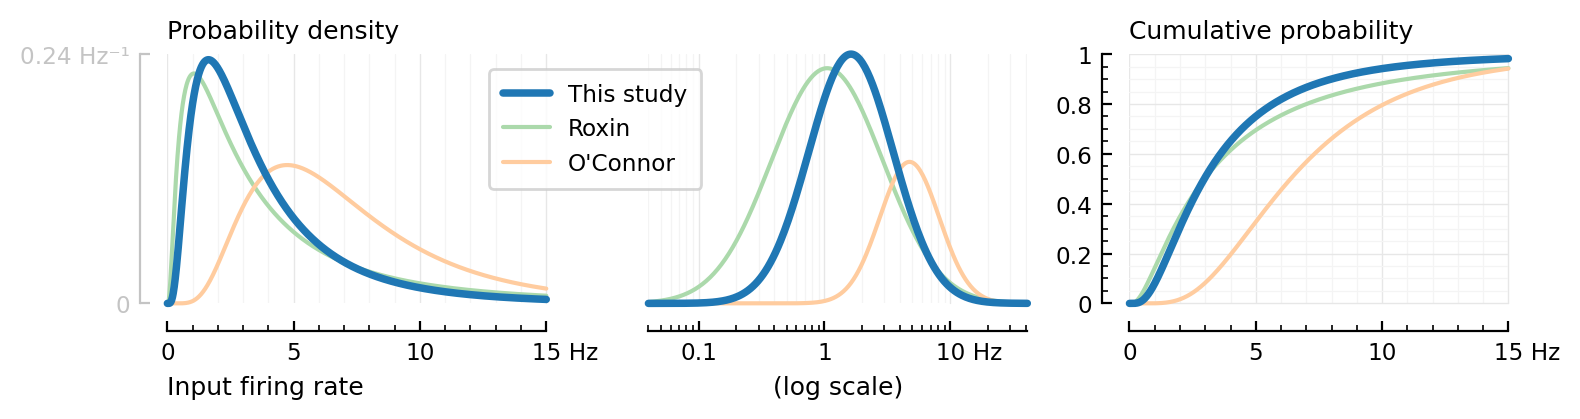

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 2.2))

rlin = (0:0.01:15) * Hz
rlog = (log10(0.04):0.01:log10(41) .|> exp10) * Hz
function plot_firing_rate_distr(distr; kw...)
    plot(rlin, pdf.(distr, rlin), ax1; clip_on=false, kw...)
    plot(rlog, pdf.(distr, rlog), ax2; clip_on=false, xscale="log", kw...)
    plot(rlin, cdf.(distr, rlin), ax3; clip_on=false, ylim=(0,1), kw...)
end

plot_firing_rate_distr(roxin, label="Roxin", c=lighten(C2, 0.4))
plot_firing_rate_distr(oconnor, label="O'Connor", c=lighten(C1, 0.4))
plot_firing_rate_distr(input_spike_rate, label="This study", c=C0, lw=2.7)

set(ax1; xlabel="Input firing rate", ytickstyle=:range, hylabel="Probability density")
set(ax2; xlabel=("(log scale)", :loc=>:center), yaxis=:off)
set(ax3; hylabel="Cumulative probability")
deemph(:yaxis, ax1)
legend(ax2, loc="center", bbox_to_anchor=(-0.14, 0.7), reorder=[3=>1])
ax2.get_legend().set_in_layout(false)
plt.tight_layout(w_pad=1)

save("log-normal.pdf")

In [12]:
distrs = [oconnor, roxin, input_spike_rate]
(df = DataFrame(
    name=["oconnor", "roxin", "this study"],
    σ=stdlogx.(distrs),
    mean=mean.(distrs),
    median=median.(distrs),
    std=std.(distrs),
    var=var.(distrs),
)) |> printsimple

 name        σ      mean (Hz)   median (Hz)   std (Hz)   var (Hz²)  
────────────────────────────────────────────────────────────────────
 oconnor     0.544  7.4         6.38          4.35       18.9
 roxin       1.02   5           2.97          6.76       45.7
 this study  0.775  4           2.96          3.63       13.2

## Sim

In [167]:
Nunconn = 100
Nexc    = 5200
Ninh    = Nexc ÷ 4

1300

In [168]:
Ninh + Nexc

6500

In [191]:
using DataStructures
using Unitful: Time

In [195]:
λ = rand(input_spike_rate, Nexc)
β = seconds.(1 ./ λ)
exps = Exponential.(β)
first_spiketimes = rand.(exps)

pq = PriorityQueue{Int, Time}()
for (i, t) in enumerate(first_spiketimes)
    enqueue!(pq, i => t)
end

sim_duration = 10*seconds;
t = 0.0*seconds
while t < sim_duration
    i, t = dequeue_pair!(pq)  # earliest spike
    new_ISI = rand(exps[i])
    enqueue!(pq, i => t + new_ISI)
end

In [199]:
using OrdinaryDiffEq
using ComponentArrays
using Parameters
using Unitful: nS, pF, pA

In [200]:
@with_kw struct IzhikevichParams
    C = 100 * pF
    k = 0.7 * (nS/mV)
    b = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV
    a = 0.03 / ms
    d = 100 * pA
end
cortical_RS = IzhikevichParams();

τ_syn = 7 * ms;

In [201]:
function f(D, vars, params, t)
    @unpack C, k, b, v_r, v_t, v_peak, c, a, d = params
    @unpack v, u = vars
    D.v = (k * (v - v_r) * (v - v_t) - u) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g / τ_syn
    return nothing
end

x0 = ComponentArray(v = -80.0mV, u = 0.0pA)
prob = ODEProblem(f, x0, float(sim_duration), cortical_RS)
Δt = 0.1ms
integrator = init(prob, Tsit5(); Δt, adaptive=true)

LoadError: UndefVarError: g not defined

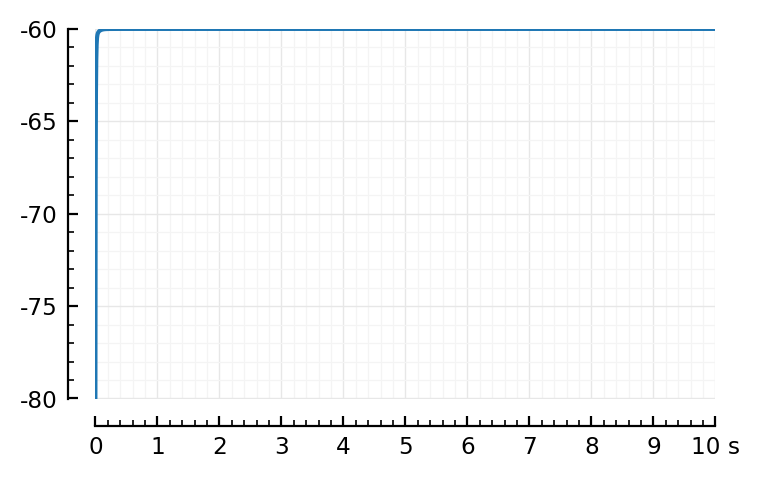

In [617]:
t = 0ms:0.1ms:sim_duration
v = t -> sol(t).v / mV |> NoUnits
plot(t, v.(t));